# Installing Packages and libraries

In [18]:
# !pip install texthero
# !pip install vaderSentiment
# !pip install pyLDAvis
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#Importing libraries

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import texthero as hero
import re

import matplotlib.pyplot as plt
import nltk

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

import spacy 
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Importing data

## NER and Vader Sentiment has already been applied on the data (NBK 2)

In [4]:
df = pd.read_pickle("/content/drive/MyDrive/MScA - UChicago/Assignments/Quarter 3 - Spring 2022/NLP/Final Project/Data/data_ner_sent.pkl")

In [5]:
df.head(1)

,date,language,title,text,title_clean,text_clean,region,ent,NER_people,NER_org,NER_norp,NER_location,text_sent,valder_sentiment
0,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...,No deal school Chicago cancels classes 2n...,CHICAGO AP Chicago school leaders canceled ...,illinois chicago,,"[Pedro Martinez, Jen Psaki, Joe Biden, Donald ...","[CHICAGO, AP, COVID, The Chicago Teachers Unio...",[],"[Chicago, Chicago, Chicago, Illinois, Skokie, ...",[CHICAGO AP Chicago school leaders canceled...,0.9485


# Filtering for Business and People and positive sentiments in these categories

In [6]:
df['people_len'] = df['NER_people'].apply(lambda x: len(x))
df['org_len'] = df['NER_org'].apply(lambda x: len(x))
df['norp_len'] = df['NER_norp'].apply(lambda x: len(x))
df['location_len'] = df['NER_location'].apply(lambda x: len(x))

In [10]:
#filtering for articles which only talk about businesses / organisations
df_business = df[(df['org_len'] > 0) & (df['people_len'] == 0)]

In [11]:
#filtering for articles which only talk about businesses / organisations
df_people = df[(df['org_len'] == 0) & (df['people_len'] > 0)]

In [30]:
del df

In [12]:
df_business.shape

(26188, 18)

In [13]:
df_people.shape

(9294, 18)

In [14]:
#filtering for only positive sentiments
df_business = df_business[df_business.valder_sentiment > 0]
df_people = df_people[df_people.valder_sentiment > 0]

In [15]:
df_business.shape

(15558, 18)

In [16]:
df_people.shape

(4804, 18)

# Running LDA Topic Modelling

In [36]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

        
def topic_modelling2(data, num_topics):
  df = data
  data_list = df['text_clean'].tolist()  

  data_tokens = []

  for sentence in data_list:
    data_tokens.append(gensim.utils.simple_preprocess(str(sentence), deacc=True))

  #Bi-grams, tri-grams and lemmatization
  bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
  trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  data_words_bigrams = [bigram_mod[doc] for doc in data_tokens]
  data_words_trigrams = [trigram_mod[bigram_mod[doc]] for doc in data_tokens]

  data_tokens_combined = data_words_trigrams

  nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

  data_lemmatized = lemmatization(data_tokens_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

  del data_tokens_combined, data_words_bigrams, data_words_trigrams, bigram_mod, trigram_mod

  dictionary = corpora.Dictionary(data_lemmatized)

  doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

  tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=num_topics,
                       random_state=100,
                       passes=10,
                       alpha='asymmetric',
                       eta='auto')

  coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)

  # if sentiment == 1:
  #   print("-"*15+"Positive Topics"+"-"*15)
  # else:
  #   print("-"*15+"Negative Topics"+"-"*15)

  pprint(tuned_lda_model.print_topics())

In [37]:
#Finiding the topics within positive sentiment for businesses.
topic_modelling2(df_business, 10)


Coherence Score:  0.39999317226717657
[(0,
  '0.006*"chicago_atlantic_real_estate" + 0.004*"https" + '
  '0.004*"latest_updated_version_experimental" + '
  '0.004*"demonstrates_full_live_operation" + 0.004*"com_video_blog_post" + '
  '0.003*"note_zennie_media_oaklandnewsnow" + 0.003*"com" + '
  '0.003*"original_blog_post_type" + 0.003*"watch" + '
  '0.003*"definitely_list_going_unite"'),
 (1,
  '0.011*"also" + 0.007*"well" + 0.003*"entrees_liquor_license_pende" + '
  '0.003*"lawyer" + 0.003*"https" + 0.002*"court" + 0.002*"work" + '
  '0.002*"company" + 0.002*"com" + 0.002*"kid"'),
 (2,
  '0.004*"get" + 0.004*"use" + 0.004*"may" + 0.004*"company" + 0.004*"also" + '
  '0.004*"time" + 0.004*"make" + 0.003*"business" + 0.003*"state" + '
  '0.003*"go"'),
 (3,
  '0.004*"also" + 0.003*"business" + 0.002*"time" + '
  '0.002*"family_law_attorneys_near" + 0.002*"company" + 0.002*"lawyer" + '
  '0.002*"well" + 0.002*"com" + 0.001*"state" + 0.001*"work"'),
 (4,
  '0.008*"also" + 0.006*"area" + 0

In [38]:
#Finiding the topics within positive sentiment for people.
topic_modelling2(df_people, 10)


Coherence Score:  0.29283225361607357
[(0,
  '0.004*"go" + 0.004*"get" + 0.003*"make" + 0.003*"also" + 0.003*"work" + '
  '0.003*"see" + 0.003*"good" + 0.003*"help" + 0.003*"may" + 0.003*"come"'),
 (1,
  '0.004*"say" + 0.004*"use" + 0.004*"get" + 0.003*"look" + 0.003*"go" + '
  '0.003*"work" + 0.003*"take" + 0.003*"may" + 0.002*"post" + 0.002*"time"'),
 (2,
  '0.004*"make" + 0.003*"get" + 0.003*"include" + 0.003*"start" + 0.003*"need" '
  '+ 0.003*"go" + 0.003*"roof" + 0.003*"work" + 0.003*"would" + 0.003*"year"'),
 (3,
  '0.004*"say" + 0.003*"find" + 0.003*"time" + 0.003*"make" + 0.003*"love" + '
  '0.003*"area" + 0.003*"may" + 0.003*"use" + 0.003*"good" + 0.003*"know"'),
 (4,
  '0.005*"come" + 0.004*"make" + 0.004*"also" + 0.004*"time" + 0.003*"go" + '
  '0.003*"see" + 0.003*"show" + 0.003*"get" + 0.003*"game" + 0.003*"start"'),
 (5,
  '0.004*"may" + 0.004*"go" + 0.004*"get" + 0.003*"company" + 0.003*"make" + '
  '0.003*"need" + 0.003*"good" + 0.003*"find" + 0.003*"use" + 0.002*"liv

# Generating word cloud

In [ ]:
text = df_business['text_clean']

string = ' '.join([str(item) for item in text])

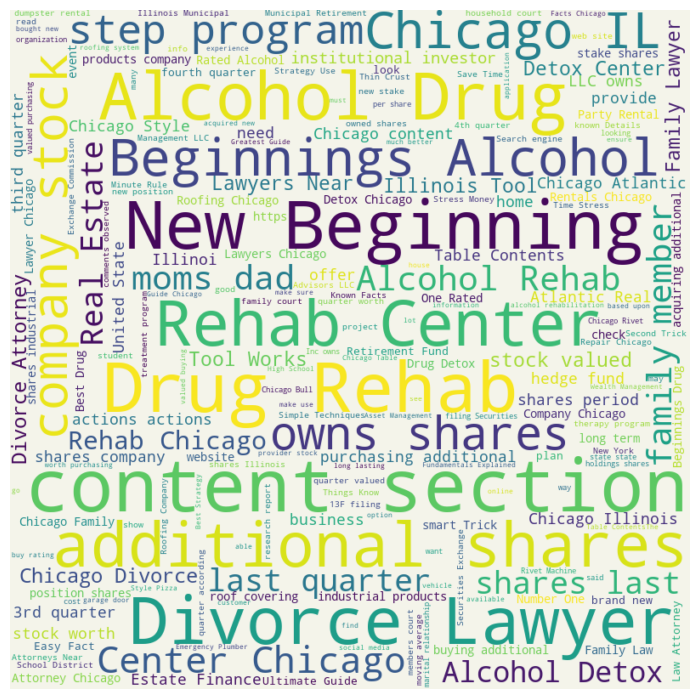

In [56]:
wordcloud = WordCloud(background_color='#f4f4ea', height = 800, width = 800).generate(string)

plt.figure(figsize=(12,9), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('business_wc.png')

In [51]:
text2 = df_people['text_clean']

string2 = ' '.join([str(item) for item in text2])

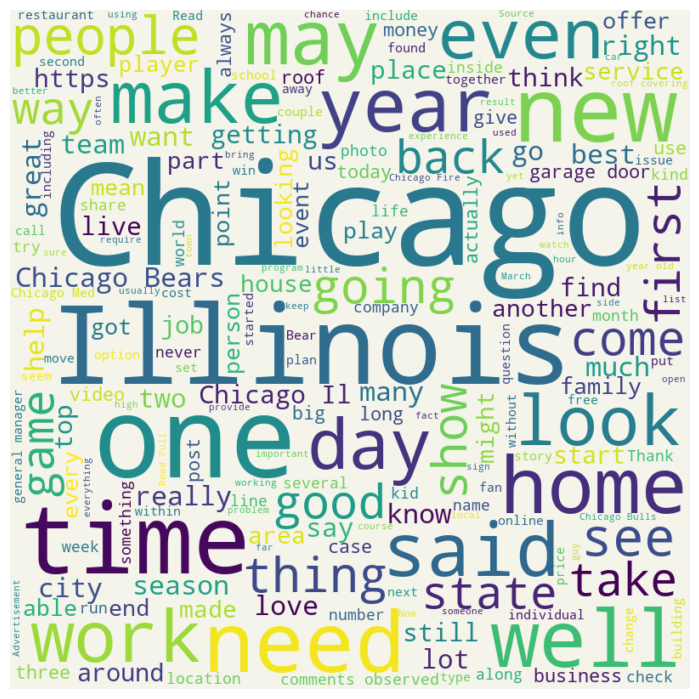

In [55]:
wordcloud = WordCloud(background_color='#f4f4ea', height = 800, width = 800).generate(string2)

plt.figure(figsize=(12,9), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('people_wc.png')